参考文献　https://qiita.com/chicken_data_analyst/items/76cbbc403293e1f4a53c

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.font_manager as fm
import matplotlib.font_manager as font_manager
from matplotlib.markers import TICKLEFT, TICKRIGHT, TICKUP, TICKDOWN, CARETLEFT, CARETRIGHT, CARETUP, CARETDOWN
from mpl_toolkits.mplot3d import axes3d, Axes3D
import sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.covariance import GraphicalLassoCV, GraphicalLasso
import scipy
import functools
import seaborn as sns
import glob
import datetime as dt
import gc
import sys
import tqdm as tq
from tqdm import tqdm
import time
import pickle
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import collections
# jpn_fonts=list(np.sort([ttf for ttf in fm.findSystemFonts() if 'ipaexg' in ttf or 'msgothic' in ttf or 'japan' in ttf or 'ipafont' in ttf]))
# jpn_font=jpn_fonts[0]
# prop = font_manager.FontProperties(fname=jpn_font)
# print(jpn_font)
# sns.set()

# import warnings
# warnings.simplefilter('ignore')

In [3]:
!pip install lingam

In [4]:
import graphviz
import lingam
from lingam.utils import make_dot,make_prior_knowledge
from lingam.utils import print_causal_directions, print_dagc

In [10]:
df_all = pd.read_csv('all_drop_exp_re.csv',encoding='shift-jis')
df_all

,Unnamed: 0,d1,d2,d3,d4,d5,w1,w2,w3,w4,...,c3,c4,c5,c6,p,none_s,image_s,announce_s,image_sound_s,image_announce_s
0,0,6.2937,1.9398,6.7618,3.07992,5.72156,36.96507,25.87807,21.29791,21.00362,...,29,21,10,6,3,1.75,3.10,3.55,3.60,3.55
1,2,7.1932,2.1034,4.9684,5.66562,8.38533,29.94836,20.88529,19.59672,20.50303,...,18,16,18,15,4,2.40,2.40,2.70,2.60,3.50
2,3,7.8981,-0.9757,4.2858,3.84009,4.87743,26.87720,18.93591,16.00807,17.58007,...,28,16,17,11,4,2.15,3.40,3.85,3.30,3.55
3,4,9.7256,0.0349,7.1680,3.90703,6.30194,43.20713,28.51156,24.68393,25.27235,...,23,24,24,23,5,1.80,4.05,4.20,3.80,4.70
4,5,4.9113,1.4880,3.0357,4.70687,6.26354,26.34567,23.30003,23.58674,17.89807,...,16,11,22,22,3,2.50,3.45,3.20,2.65,3.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,796,7.0463,-1.1722,4.3281,2.71297,7.12817,20.17931,10.61594,10.69781,8.36414,...,26,31,21,13,5,2.25,2.50,3.80,2.30,3.35
636,797,8.5748,-1.1702,4.7669,4.87733,7.84963,27.71802,19.01448,16.56406,16.81861,...,30,14,14,10,5,2.50,3.10,3.90,3.20,3.80
637,798,10.2154,-1.1652,5.1767,2.77794,4.07748,21.64954,14.42384,14.39132,14.72991,...,36,13,21,29,2,2.95,2.90,2.80,2.90,2.85
638,802,8.6738,-0.4216,1.4291,4.27503,5.49286,31.06191,21.50243,19.40287,18.43385,...,28,26,17,6,4,2.20,4.25,4.20,3.90,4.30


In [11]:
df_all = df_all[['d1', 'd2', 'd3', 'd4', 'd5']]

In [12]:
df_all.describe()

,d1,d2,d3,d4,d5
count,640.000000,640.000000,640.000000,640.000000,640.000000
mean,6.219847,0.460025,4.463986,3.686702,5.692682
std,2.228616,1.504184,1.618577,1.079367,1.234064
min,-0.753800,-2.851000,0.844100,1.774170,2.625490
25%,4.557875,-0.644450,3.321675,2.850433,4.870975
50%,6.211050,0.203800,4.288700,3.512340,5.591330
75%,7.762150,1.417725,5.554575,4.263863,6.418975
max,11.550000,6.520000,8.202800,7.389040,9.488850


In [13]:
new_column_names = {'d1': '安全運転特性', 'd2': '不安定な運転特性','d3': '心配性特性', 'd4': 'ステイタス特性', 'd5': '事前準備特性','w1': '道路状況把握負担', 'w2': '心身状況負担','w3': '運転ペース阻害負担', 'w4': '車環境負担','w5': '視野環境負担','c1': '写真タイプ', 'c2': '三次元映像タイプ','c3': '言語映像タイプ', 'c4': '言語抽象タイプ','c5': '聴覚言語タイプ', 'c6': '聴覚&音タイプ','p': '行動変容フェーズ', 'none_s': '提示なし','image_s': '画像のみ', 'announce_s': '音声のみ','image_sound_s': '画像+報知音', 'image_announce_s': '画像+音声'}

In [14]:
df_all = df_all.rename(columns=new_column_names)

In [15]:
colsname = df_all.columns
colsname

Index(['安全運転特性', '不安定な運転特性', '心配性特性', 'ステイタス特性', '事前準備特性'], dtype='object')

In [16]:
# df_sampleを標準化
df_std = df_all.copy()
ss = sklearn.preprocessing.StandardScaler()
df_std = pd.DataFrame(ss.fit_transform(df_std), columns=colsname)
display(df_std)

,安全運転特性,不安定な運転特性,心配性特性,ステイタス特性,事前準備特性
0,0.033164,0.984542,1.420761,-0.562605,0.023419
1,0.437094,1.093391,0.311884,1.834840,2.183642
2,0.753636,-0.955234,-0.110174,0.142220,-0.661140
3,1.574293,-0.282849,1.671918,0.204287,0.494087
4,-0.587616,0.683945,-0.883123,0.945893,0.462946
...,...,...,...,...,...
635,0.371127,-1.085972,-0.084020,-0.902838,1.164130
636,1.057515,-1.084641,0.187294,1.103943,1.749209
637,1.794243,-1.081315,0.440678,-0.842599,-1.309871
638,1.101972,-0.586574,-1.876500,0.545494,-0.162048


事前知識　https://qiita.com/ts5129nk/items/03d6a73c36ecedad2535

In [17]:
# prior_knowledge = make_prior_knowledge(
#     n_variables=10,
#     sink_variables=[5,6,7,8,9],
# )

In [18]:
%%time
# DirectLiNGAM
print(time.ctime())
# model = lingam.DirectLiNGAM(prior_knowledge=prior_knowledge)
model = lingam.DirectLiNGAM()
model.fit(df_std)
print(time.ctime())

# DAGを保存するなら実行
save_pickle = 'pickles'
os.makedirs(save_pickle, exist_ok=True)
#with open(save_pickle+'/model_DLingam.pickle', mode='wb') as f:
#    pickle.dump(model, f)


Fri Aug 16 09:10:29 2024
Fri Aug 16 09:10:29 2024
CPU times: user 16.6 ms, sys: 1.91 ms, total: 18.5 ms
Wall time: 21.1 ms


/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36939 (\N{CJK UNIFIED IDEOGRAPH-904B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36578 (\N{CJK UNIFIED IDEOGRAPH-8EE2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  fig.canvas.print_figure(b

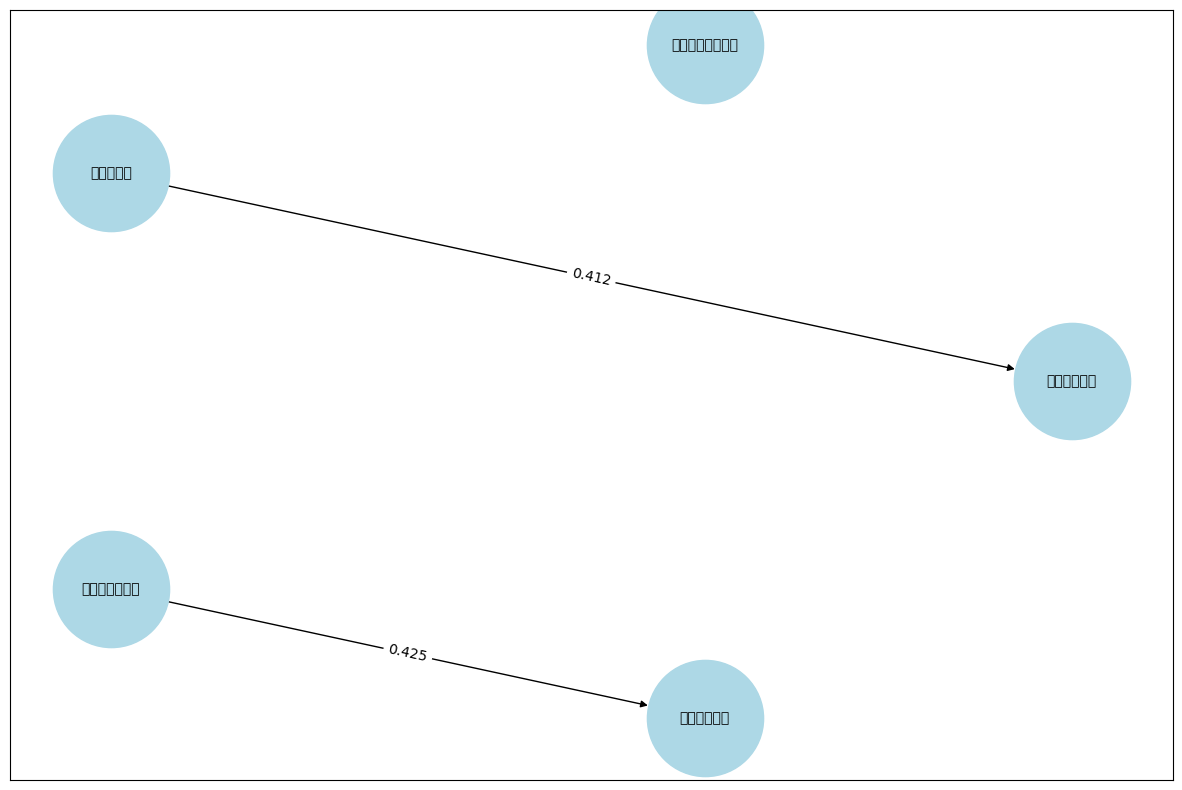

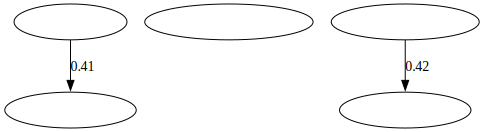

In [19]:
# 隣接行列の取得
adjacency_matrix = model.adjacency_matrix_

# フィルタリング
threshold = 0.30
filtered_adjacency_matrix = np.where(np.abs(adjacency_matrix) > threshold, adjacency_matrix, 0)

# 有向グラフの作成
G = nx.from_numpy_array(filtered_adjacency_matrix.T, create_using=nx.DiGraph)
G = nx.relabel_nodes(G, dict(enumerate(colsname)))

# エッジラベルの作成
edge_labels = {(u, v): f"{d['weight']:.3f}" for u, v, d in G.edges(data=True) if np.abs(d['weight']) > threshold}

# グラフの描画
plt.figure(figsize=(15, 10))
pos = nx.circular_layout(G)
nx.draw_networkx(G, pos, node_size=7000, node_color='lightblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.grid(False)
plt.show()

# make_dotを用いた可視化
filtered_adjacency_matrix_dot = np.where(np.abs(adjacency_matrix) > threshold, adjacency_matrix, 0)
make_dot(filtered_adjacency_matrix_dot, labels=list(colsname))

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36939 (\N{CJK UNIFIED IDEOGRAPH-904B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36578 (\N{CJK UNIFIED IDEOGRAPH-8EE2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  fig.canvas.print_figure(b

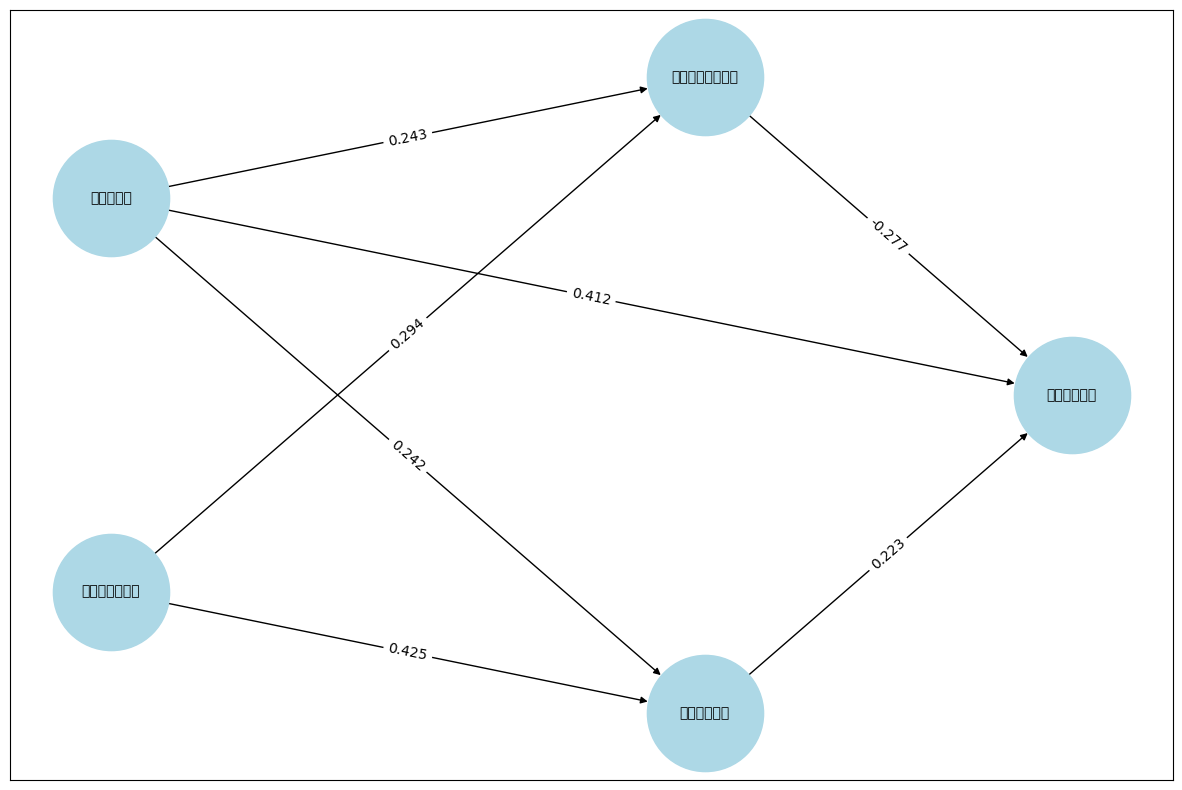

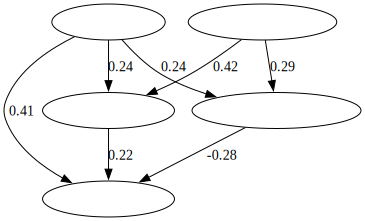

In [20]:
# 隣接行列の取得
adjacency_matrix = model.adjacency_matrix_

# フィルタリング
threshold = 0.20
filtered_adjacency_matrix = np.where(np.abs(adjacency_matrix) > threshold, adjacency_matrix, 0)

# 有向グラフの作成
G = nx.from_numpy_array(filtered_adjacency_matrix.T, create_using=nx.DiGraph)
G = nx.relabel_nodes(G, dict(enumerate(colsname)))

# エッジラベルの作成
edge_labels = {(u, v): f"{d['weight']:.3f}" for u, v, d in G.edges(data=True) if np.abs(d['weight']) > threshold}

# グラフの描画
plt.figure(figsize=(15, 10))
pos = nx.circular_layout(G)
nx.draw_networkx(G, pos, node_size=7000, node_color='lightblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.grid(False)
plt.show()

# make_dotを用いた可視化
filtered_adjacency_matrix_dot = np.where(np.abs(adjacency_matrix) > threshold, adjacency_matrix, 0)
make_dot(filtered_adjacency_matrix_dot, labels=list(colsname))

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36939 (\N{CJK UNIFIED IDEOGRAPH-904B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36578 (\N{CJK UNIFIED IDEOGRAPH-8EE2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  fig.canvas.print_figure(b

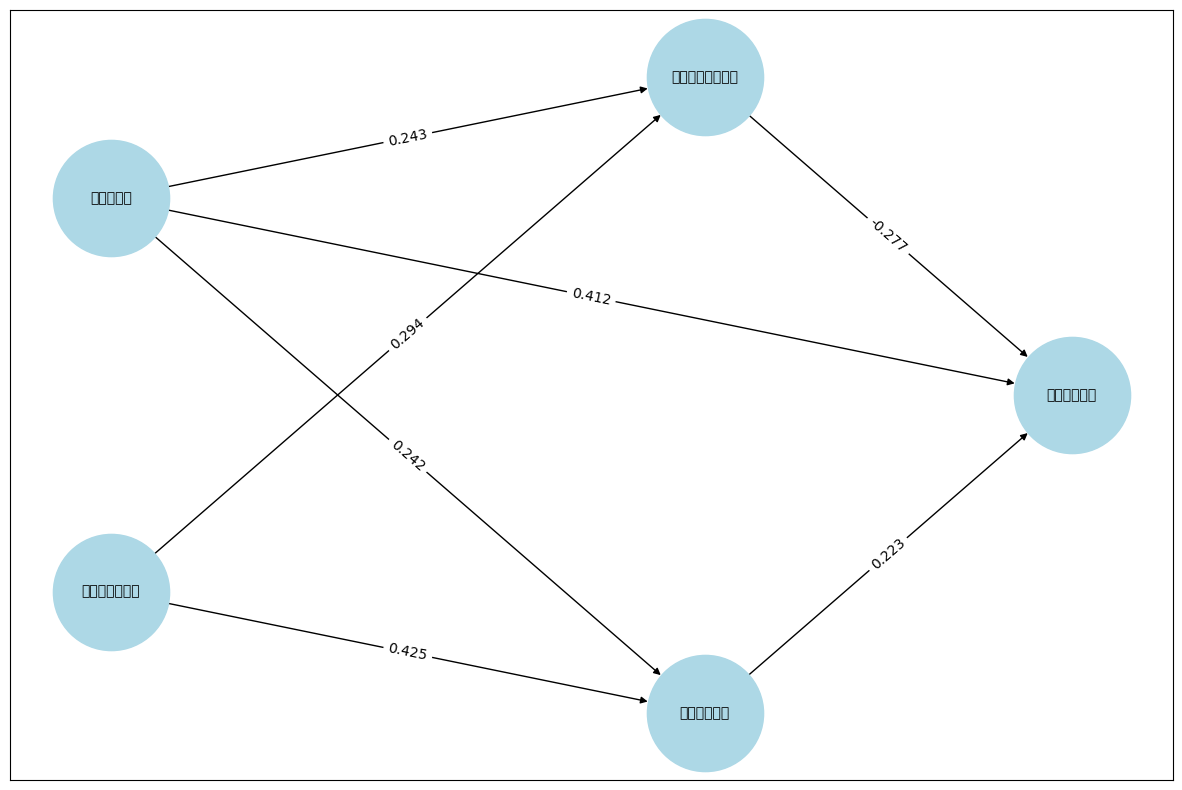

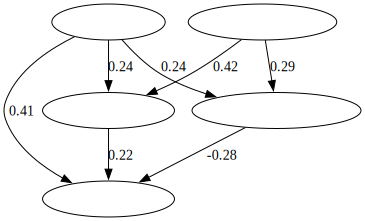

In [21]:
# 隣接行列の取得
adjacency_matrix = model.adjacency_matrix_

# フィルタリング
threshold = 0.1
filtered_adjacency_matrix = np.where(np.abs(adjacency_matrix) > threshold, adjacency_matrix, 0)

# 有向グラフの作成
G = nx.from_numpy_array(filtered_adjacency_matrix.T, create_using=nx.DiGraph)
G = nx.relabel_nodes(G, dict(enumerate(colsname)))

# エッジラベルの作成
edge_labels = {(u, v): f"{d['weight']:.3f}" for u, v, d in G.edges(data=True) if np.abs(d['weight']) > threshold}

# グラフの描画
plt.figure(figsize=(15, 10))
pos = nx.circular_layout(G)
nx.draw_networkx(G, pos, node_size=7000, node_color='lightblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.grid(False)
plt.show()

# make_dotを用いた可視化
filtered_adjacency_matrix_dot = np.where(np.abs(adjacency_matrix) > threshold, adjacency_matrix, 0)
make_dot(filtered_adjacency_matrix_dot, labels=list(colsname))

<Figure size 1500x1000 with 0 Axes>

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36939 (\N{CJK UNIFIED IDEOGRAPH-904B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36578 (\N{CJK UNIFIED IDEOGRAPH-8EE2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  fig.canvas.print_figure(b

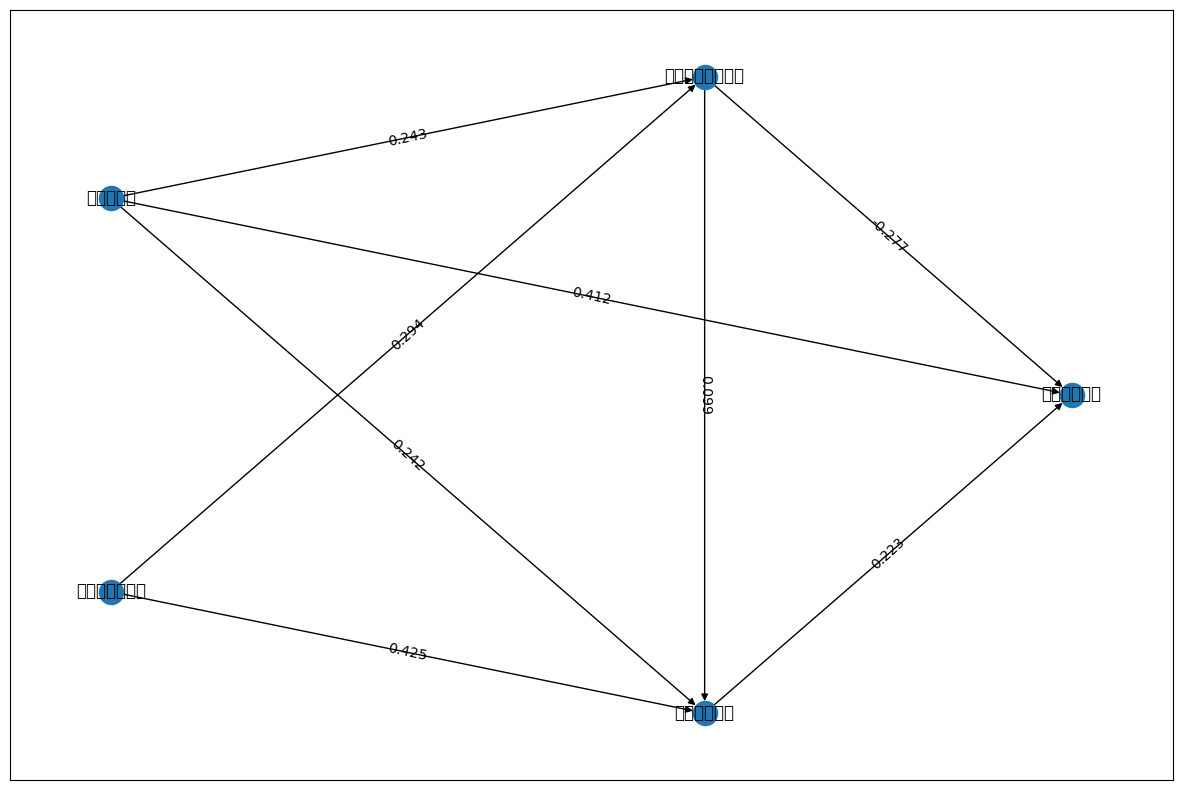

In [22]:
# 想定される因果
G = nx.DiGraph()  # 有向グラフ (Directed Graph)
# 頂点の追加
#G.add_node('Air temperature [K]')                
G.add_nodes_from(colsname)

# 隣接行列を有向グラフで可視化(networkx使用)
plt.figure(figsize=(15,10))
pos = nx.circular_layout(G, scale=1, center=None, dim=2)  # ここのポジションをこの先のplotでも使用する
# #pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
# nx.draw_networkx(G, pos)
# plt.grid(False)
# plt.show()
adjacency_ = pd.DataFrame(model.adjacency_matrix_, columns=colsname, index=colsname)
G=nx.from_pandas_adjacency(adjacency_.T, create_using=nx.DiGraph)  # 列が原因、行が結果なのでnetworkxでは転置の必要がある
plt.figure(figsize=(15,10))
#pos = nx.bipartite_layout(G, colsname[:5])
#pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
edge_labels = dict([((u,v,), f"{d['weight']:.3f}") for u,v,d in G.edges(data=True)])#nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)
nx.draw_networkx(G, pos)
plt.grid(False)
plt.show()

[3, 2, 1, 4, 0]
['ステイタス特性' '心配性特性' '不安定な運転特性' '事前準備特性' '安全運転特性']


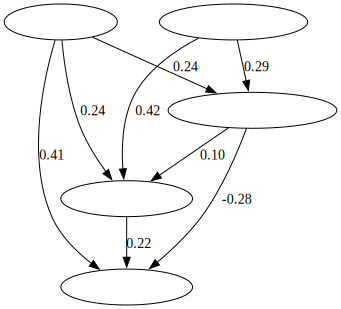

In [23]:
# 隣接行列を有向グラフで可視化(make_dot使用)
print(model.causal_order_)
print(np.array(colsname)[model.causal_order_])
#print(model.adjacency_matrix_)
make_dot(model.adjacency_matrix_, labels=list(colsname))

ブートストラップ法　参考URL https://qiita.com/ts5129nk/items/03d6a73c36ecedad2535

In [24]:
# #ブートストラップ実行
# result = model.bootstrap(x, n_sampling=100)
# #結果の表示
# causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

# df_b = pd.DataFrame(causal_effects)
# df_b['from'] = df_b['from'].apply(lambda x : colsname[x])
# df_b['to'] = df_b['to'].apply(lambda x : colsname[x])
# #効果の降順でソート
# df_b=df_b.sort_values('effect', ascending=False)
# df_b

In [25]:
%%time
# DirectLiNGAM bootstrap
print(time.ctime())
n_sampling = 100
model = lingam.DirectLiNGAM()
result = model.bootstrap(df_std, n_sampling=n_sampling)
print(time.ctime())

# DAGを保存するなら実行
save_pickle = 'pickles'
os.makedirs(save_pickle, exist_ok=True)
#with open(save_pickle+'/model_DLingam_bootstrap.pickle', mode='wb') as f:
#    pickle.dump(model, f)

Fri Aug 16 09:10:34 2024
Fri Aug 16 09:10:35 2024
CPU times: user 942 ms, sys: 8.05 ms, total: 950 ms
Wall time: 1.01 s


[3, 1, 4, 2, 0]
['ステイタス特性' '不安定な運転特性' '事前準備特性' '心配性特性' '安全運転特性']


/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36939 (\N{CJK UNIFIED IDEOGRAPH-904B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36578 (\N{CJK UNIFIED IDEOGRAPH-8EE2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  fig.canvas.print_figure(b

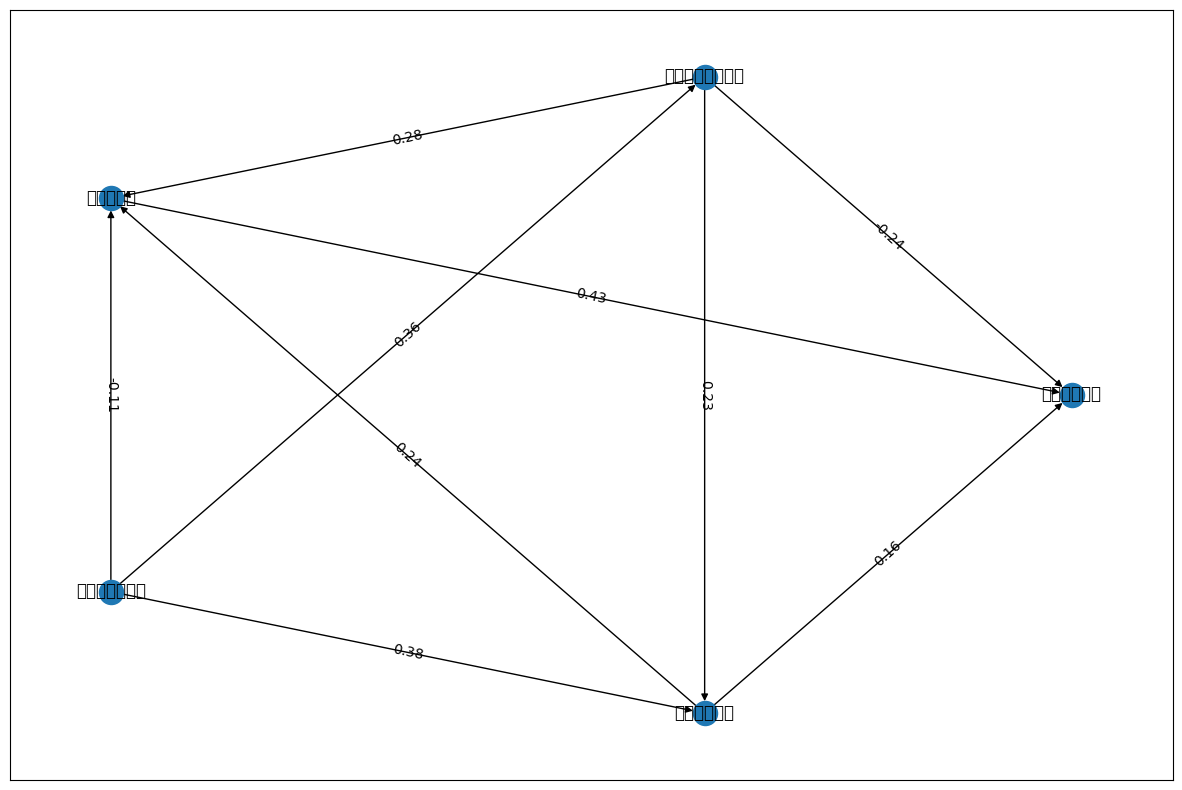

In [26]:
# 隣接行列を有向グラフで可視化(networkx使用)
print(model.causal_order_)
print(np.array(colsname)[model.causal_order_])
#print(model.adjacency_matrix_)

adjacency_ = pd.DataFrame(model.adjacency_matrix_, columns=colsname, index=colsname)
G=nx.from_pandas_adjacency(adjacency_.T, create_using=nx.DiGraph)  # 列が原因、行が結果なのでnetworkxでは転置の必要がある
plt.figure(figsize=(15,10))
#pos = nx.bipartite_layout(G, colsname[:5])
#pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
edge_labels = edge_labels = dict([((u,v,), f"{d['weight']:.2f}") for u,v,d in G.edges(data=True)])#nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)
nx.draw_networkx(G, pos)
plt.grid(False)
plt.show()

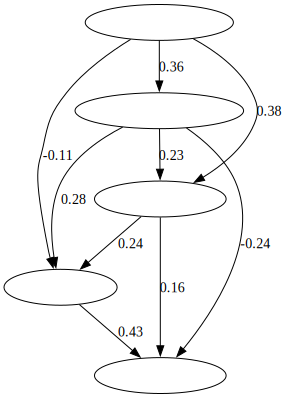

In [27]:
# 隣接行列を有向グラフで可視化(make_dot使用)
make_dot(model.adjacency_matrix_, labels=list(colsname))

In [28]:
%%time
# DirectLiNGAM bootstrap result
print(time.ctime())
dagc = result.get_directed_acyclic_graph_counts(n_dags=5, min_causal_effect=0.1, split_by_causal_effect_sign=True)
print_dagc(dagc, n_sampling)
print(time.ctime())

Fri Aug 16 09:10:35 2024
DAG[0]: 17.0%
	x0 <--- x1 (b<0)
	x0 <--- x2 (b>0)
	x0 <--- x4 (b>0)
	x1 <--- x2 (b>0)
	x1 <--- x3 (b>0)
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)
DAG[1]: 14.0%
	x0 <--- x1 (b<0)
	x0 <--- x2 (b>0)
	x0 <--- x4 (b>0)
	x1 <--- x2 (b>0)
	x1 <--- x3 (b>0)
	x4 <--- x1 (b>0)
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)
DAG[2]: 10.0%
	x0 <--- x1 (b<0)
	x0 <--- x2 (b>0)
	x0 <--- x4 (b>0)
	x1 <--- x3 (b>0)
	x2 <--- x1 (b>0)
	x4 <--- x1 (b>0)
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)
DAG[3]: 6.0%
	x0 <--- x1 (b<0)
	x0 <--- x2 (b>0)
	x0 <--- x3 (b>0)
	x1 <--- x2 (b>0)
	x1 <--- x3 (b>0)
	x4 <--- x0 (b>0)
	x4 <--- x1 (b>0)
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)
DAG[4]: 5.0%
	x0 <--- x1 (b<0)
	x0 <--- x2 (b>0)
	x0 <--- x4 (b>0)
	x1 <--- x2 (b>0)
	x1 <--- x3 (b>0)
	x2 <--- x3 (b>0)
	x4 <--- x1 (b>0)
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)
Fri Aug 16 09:10:35 2024
CPU times: user 2.58 ms, sys: 1.59 ms, total: 4.16 ms
Wall time: 3.01 ms


In [29]:
%%time
# DirectLiNGAM bootstrap result
print(time.ctime())
cdc = result.get_causal_direction_counts(n_directions=10, min_causal_effect=0.1, split_by_causal_effect_sign=True)
print_causal_directions(cdc, n_sampling)
print(time.ctime())

Fri Aug 16 09:10:36 2024
x0 <--- x2 (b>0) (98.0%)
x0 <--- x1 (b<0) (94.0%)
x4 <--- x3 (b>0) (93.0%)
x1 <--- x3 (b>0) (84.0%)
x0 <--- x4 (b>0) (78.0%)
x4 <--- x2 (b>0) (78.0%)
x4 <--- x1 (b>0) (69.0%)
x1 <--- x2 (b>0) (65.0%)
x2 <--- x1 (b>0) (35.0%)
x4 <--- x0 (b>0) (22.0%)
Fri Aug 16 09:10:36 2024
CPU times: user 4.44 ms, sys: 2.61 ms, total: 7.04 ms
Wall time: 5.53 ms


In [30]:
for i in range(0, 22):
    print(f'x{i} : {colsname[i]}')

x0 : 安全運転特性
x1 : 不安定な運転特性
x2 : 心配性特性
x3 : ステイタス特性
x4 : 事前準備特性


IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
%%time
# DirectLiNGAM bootstrap result
print(time.ctime())
prob = result.get_probabilities(min_causal_effect=0.1)
prob = np.where(prob<0.01, 0, prob)
prob = pd.DataFrame(prob, columns=colsname, index=colsname)
display(prob)
print(time.ctime())

Sun Jun 16 19:43:18 2024


,安全運転特性,不安定な運転特性,心配性特性,ステイタス特性,事前準備特性,道路状況把握負担,心身状況負担,運転ペース阻害負担,車環境負担,視野環境負担,...,言語映像タイプ,言語抽象タイプ,聴覚言語タイプ,聴覚&音タイプ,行動変容フェーズ,提示なし,画像のみ,音声のみ,画像+報知音,画像+音声
安全運転特性,0.00,0.59,0.94,0.34,0.46,0.34,0.32,0.59,0.29,0.37,...,0.03,0.05,0.09,0.01,0.94,0.02,0.10,0.17,0.00,0.29
不安定な運転特性,0.39,0.00,0.61,0.85,0.15,0.30,0.03,0.63,0.54,0.53,...,0.02,0.01,0.32,0.01,0.93,0.01,0.06,0.28,0.07,0.31
心配性特性,0.06,0.38,0.00,0.30,0.15,0.43,0.10,0.05,0.28,0.07,...,0.01,0.01,0.23,0.01,0.03,0.00,0.02,0.06,0.05,0.02
ステイタス特性,0.06,0.15,0.20,0.00,0.07,0.40,0.06,0.19,0.12,0.22,...,0.03,0.06,0.09,0.21,0.04,0.06,0.07,0.06,0.05,0.08
事前準備特性,0.54,0.81,0.85,0.93,0.00,0.24,0.29,0.43,0.13,0.76,...,0.00,0.00,0.70,0.00,0.03,0.00,0.00,0.04,0.00,0.03
道路状況把握負担,0.08,0.07,0.46,0.43,0.04,0.00,0.39,0.40,0.29,0.39,...,0.00,0.10,0.02,0.06,0.00,0.02,0.02,0.28,0.02,0.22
心身状況負担,0.03,0.00,0.05,0.03,0.00,0.61,0.00,0.19,0.67,0.45,...,0.00,0.01,0.00,0.01,0.00,0.02,0.01,0.02,0.00,0.21
運転ペース阻害負担,0.09,0.16,0.06,0.14,0.07,0.60,0.21,0.00,0.41,0.52,...,0.00,0.01,0.01,0.00,0.11,0.00,0.01,0.23,0.00,0.05
車環境負担,0.02,0.16,0.08,0.20,0.01,0.65,0.33,0.59,0.00,0.25,...,0.00,0.00,0.00,0.00,0.03,0.01,0.00,0.00,0.00,0.01
視野環境負担,0.01,0.13,0.04,0.08,0.05,0.61,0.44,0.48,0.12,0.00,...,0.01,0.04,0.02,0.00,0.00,0.00,0.01,0.02,0.00,0.01


Sun Jun 16 19:43:18 2024
CPU times: user 14.4 ms, sys: 1.8 ms, total: 16.2 ms
Wall time: 51.7 ms


In [31]:
from_index = 0 # index of x0
to_index = 1 # index of x3
# 開始変数から終了変数までのすべてのパスとそのブートストラップ確率を取得
display(pd.DataFrame(result.get_paths(from_index, to_index)))
print(time.ctime())

,path,effect,probability
0,"[0, 1]",-0.308506,0.06


Fri Aug 16 09:10:37 2024


In [32]:
import pandas as pd
from itertools import product

# 0から21の範囲で全てのfrom_indexとto_indexの組み合わせを生成
index_range = range(22)
index_combinations = list(product(index_range, index_range))

# 結果を格納するためのデータフレームリスト
filtered_paths_list = []

# 各組み合わせについてパスを取得してフィルタリング
for from_index, to_index in index_combinations:
    if from_index != to_index:
        paths_df = pd.DataFrame(result.get_paths(from_index, to_index))
        filtered_paths_df = paths_df[paths_df['probability'] >= 0.5]
        if not filtered_paths_df.empty:
            filtered_paths_df['from_index'] = from_index
            filtered_paths_df['to_index'] = to_index
            filtered_paths_list.append(filtered_paths_df)

# すべてのフィルタリングされたパスを結合
all_filtered_paths_df = pd.concat(filtered_paths_list, ignore_index=True)

# フィルタリングされたデータフレームを表示
display(all_filtered_paths_df)

# 現在の時刻を表示
print(time.ctime())

/var/folders/5r/3m3ng3v11j57dkl0psc9lphh0000gn/T/ipykernel_44784/3045054659.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_paths_df['from_index'] = from_index
/var/folders/5r/3m3ng3v11j57dkl0psc9lphh0000gn/T/ipykernel_44784/3045054659.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_paths_df['to_index'] = to_index
/var/folders/5r/3m3ng3v11j57dkl0psc9lphh0000gn/T/ipykernel_44784/3045054659.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

IndexError: list index out of range

In [ ]:
all_filtered_paths_df

,path,effect,probability,from_index,to_index
0,"[1, 0]",-0.190582,0.67,1,0
1,"[1, 2]",0.210952,0.51,1,2
2,"[1, 4]",0.205958,0.85,1,4
3,"[2, 0]",0.378362,0.94,2,0
4,"[2, 4]",0.207954,0.73,2,4
5,"[3, 1, 0]",-0.066565,0.57,3,0
6,"[3, 4, 0]",0.093145,0.52,3,0
7,"[3, 1]",0.344291,0.88,3,1
8,"[3, 4]",0.366961,0.94,3,4
9,"[3, 1, 4]",0.067825,0.73,3,4


In [33]:
df_all_filltered_paths  = pd.DataFrame(all_filtered_paths_df)
df_all_filltered_paths['from_index'] = df_all_filltered_paths['from_index'].apply(lambda x : colsname[x])
df_all_filltered_paths['to_index'] = df_all_filltered_paths['to_index'].apply(lambda x : colsname[x])
df_all_filltered_paths 

NameError: name 'all_filtered_paths_df' is not defined

In [34]:
df_all_filltered_paths[30:]

NameError: name 'df_all_filltered_paths' is not defined

In [35]:
df_all.to_csv('df_all_filltered_paths.csv')

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36939 (\N{CJK UNIFIED IDEOGRAPH-904B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36578 (\N{CJK UNIFIED IDEOGRAPH-8EE2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  fig.canvas.print_figure(b

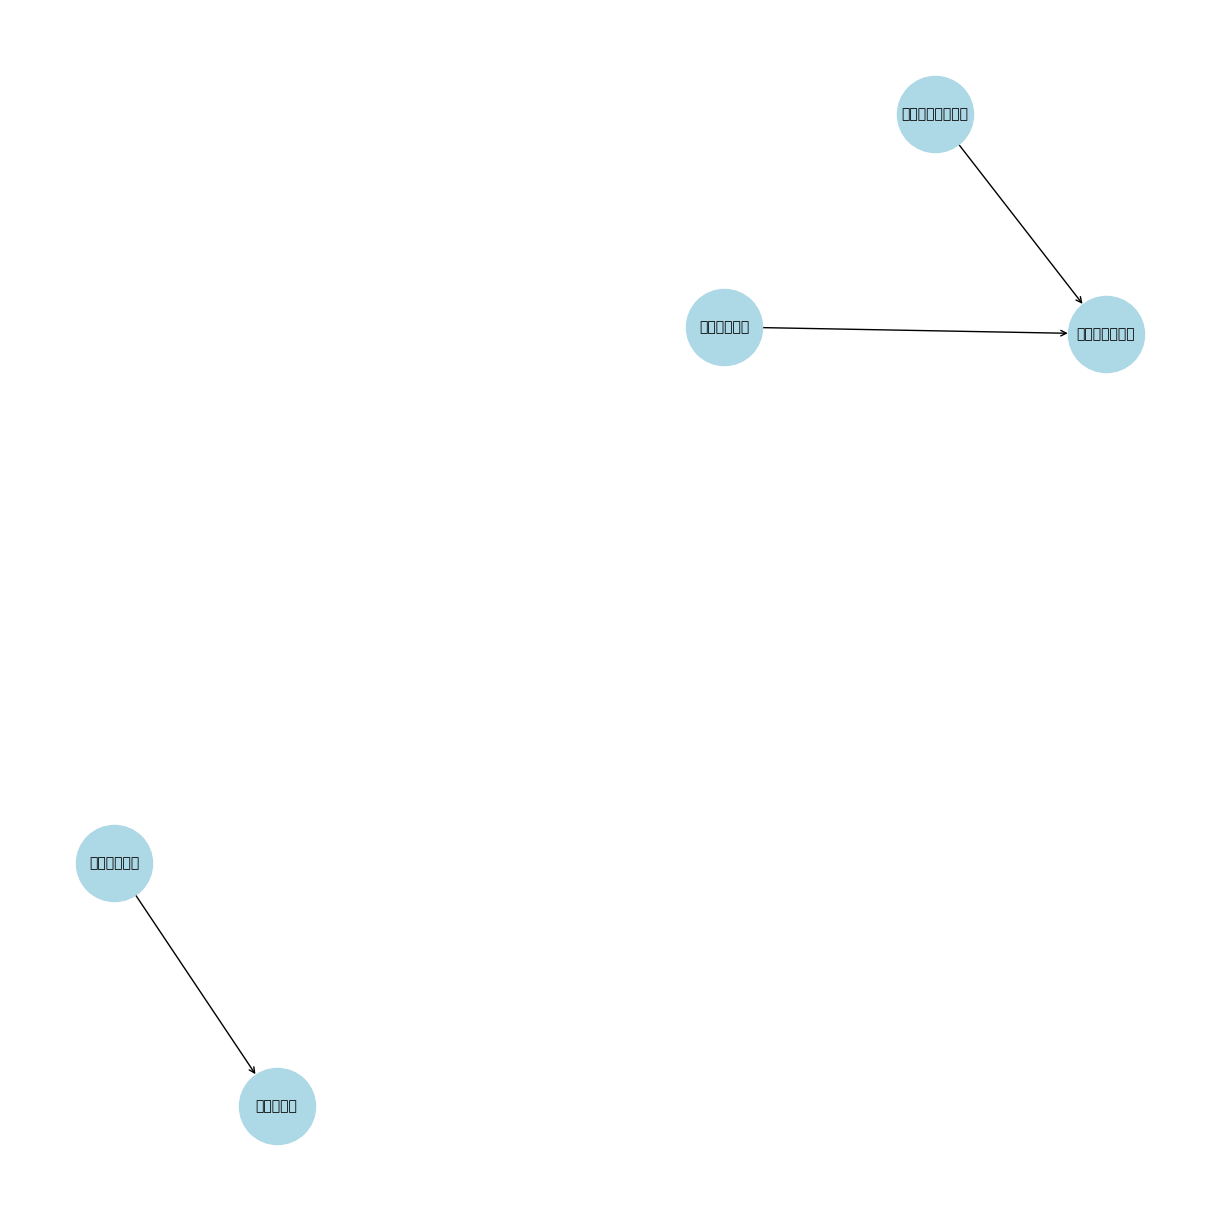

In [36]:
adj_matrix = model.adjacency_matrix_
threshold = 0.29
filtered_matrix = np.where(np.abs(adj_matrix) > threshold, adj_matrix, 0)

# Optionally, you can visualize the filtered adjacency matrix
def plot_adjacency_matrix(matrix, labels):
    G = nx.DiGraph(matrix)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, labels={i: labels[i] for i in range(len(labels))}, 
            node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', 
            arrows=True, arrowstyle='->', arrowsize=10, edge_color='black')
    plt.show()

# If df_std is a DataFrame, use its columns as labels
if isinstance(df_std, pd.DataFrame):
    labels = df_std.columns
else:
    labels = range(len(filtered_matrix))

plot_adjacency_matrix(filtered_matrix, labels)

In [37]:
%%time
# RCD
print(time.ctime())
model = lingam.RCD()
model.fit(df_std)
print(time.ctime())

# DAGを保存するなら実行
save_pickle = 'pickles'
os.makedirs(save_pickle, exist_ok=True)
#with open(save_pickle+'/model_RCD.pickle', mode='wb') as f:
#    pickle.dump(model, f)

Fri Aug 16 09:10:41 2024
Fri Aug 16 09:10:41 2024
CPU times: user 1.62 s, sys: 119 ms, total: 1.74 s
Wall time: 268 ms


/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36939 (\N{CJK UNIFIED IDEOGRAPH-904B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36578 (\N{CJK UNIFIED IDEOGRAPH-8EE2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  fig.canvas.print_figure(b

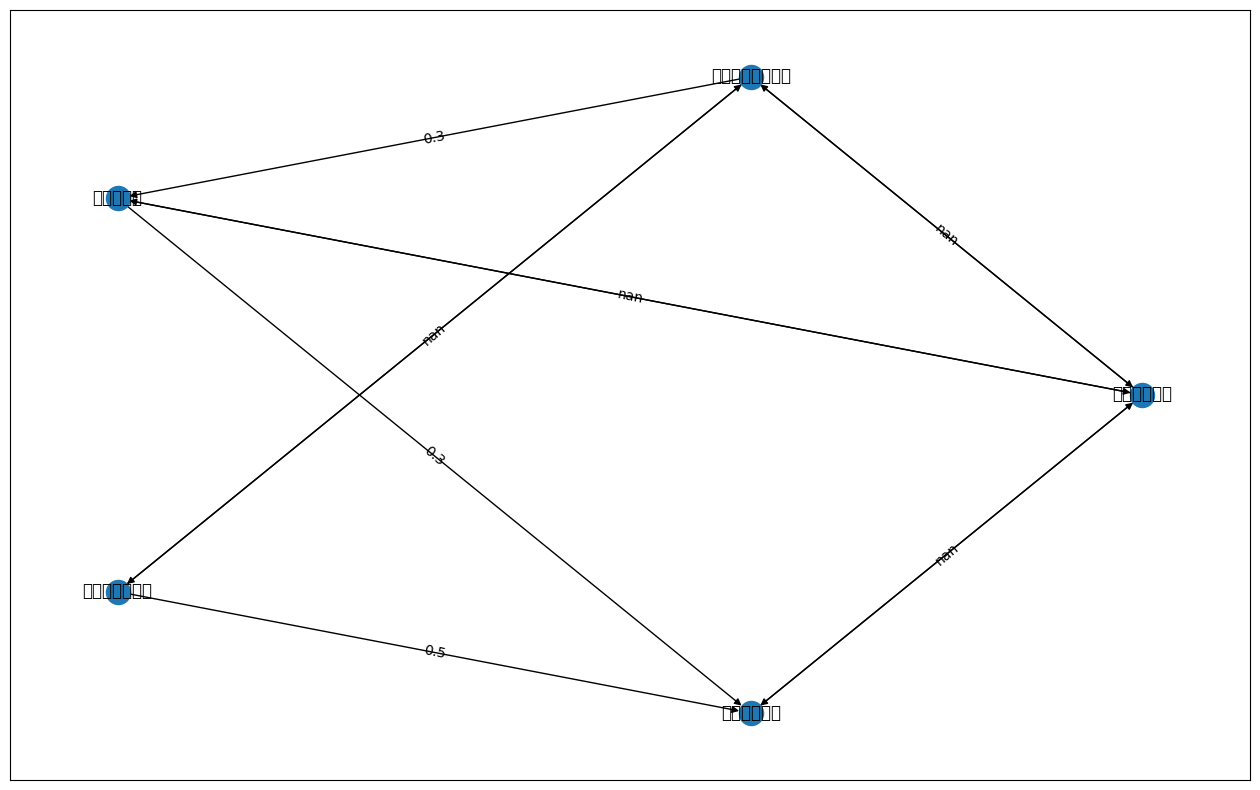

In [38]:
# 隣接行列を有向グラフで可視化(networkx使用)
#print(model.causal_order_)
#print(np.array(colsname)[model.causal_order_])
#print(model.adjacency_matrix_)

adjacency_ = pd.DataFrame(model.adjacency_matrix_, columns=colsname, index=colsname)
G=nx.from_pandas_adjacency(adjacency_.T, create_using=nx.DiGraph)  # 列が原因、行が結果なのでnetworkxでは転置の必要がある
plt.figure(figsize=(16,10))
#pos = nx.bipartite_layout(G, colsname[:5])
#pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
edge_labels = edge_labels = dict([((u,v,), f"{d['weight']:.1f}") for u,v,d in G.edges(data=True)])#nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)
nx.draw_networkx(G, pos)
plt.grid(False)
plt.show()

# 隣接行列を有向グラフで可視化(make_dot使用)
#make_dot(model.adjacency_matrix_, labels=colsname)

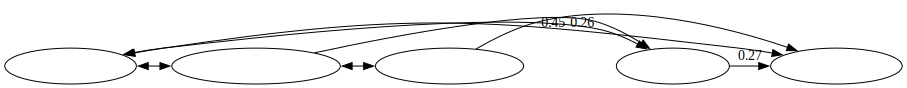

In [39]:
# 隣接行列を有向グラフで可視化(make_dot使用)
make_dot(model.adjacency_matrix_, labels=list(colsname))